# NLP: Classify Articles from Titles

We will walk through an end-to-end example of taking the raw text of the articles' titles, clean it, tokenize and vectorize it, explore it, and develop a model to classify each article into one of 4 labeled classes (business, sports, technology, or entertainment). 

In [73]:
import unicodedata
import re
import json

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# matplotlib default plotting styles
plt.rc("patch", edgecolor="black", force_edgecolor=True)
plt.rc("axes", grid=True)
plt.rc("grid", linestyle=":", linewidth=0.8, alpha=0.7)
plt.rc("axes.spines", right=False, top=False)
plt.rc("figure", figsize=(11, 8))
plt.rc("font", size=12.0)
plt.rc("hist", bins=25)

import acquire

## Acquire: Scrape InShorts.com

Acquire news articles from [InShorts](inshorts.com) using `BeautifulSoup` and `get.requests`

- [business](https://inshorts.com/en/read/business)
- [sports](https://inshorts.com/en/read/sports)
- [technology](https://inshorts.com/en/read/technology)
- [entertainment](https://inshorts.com/en/read/entertainment)

In [74]:
original_df = acquire.get_news_articles()

In [75]:
original_df.head()

,Unnamed: 0,author,category,content,published_date,title
0,0,Pragya Swastik,business,Former Finance Minister P Chidambaram on Thurs...,2019-12-05T10:41:04.000Z,"8, 7, 6.6, 5.8, 5 & 4.5 is the state of econom..."
1,1,Kanishka Pandey,business,Google Co-founders Sergey Brin and Larry Page ...,2019-12-05T06:36:23.000Z,Google Co-founders gain $2.3B after Sundar Pic...
2,2,Kanishka Pandey,business,Google's 47-year-old India-born CEO Sundar Pic...,2019-12-06T03:32:57.000Z,Sundar Pichai rejected Google shares worth mil...
3,3,Kanishka Pandey,business,"SoftBank Founder and CEO Masayoshi Son, in a d...",2019-12-06T11:27:06.000Z,Gut feeling drove me to invest $20M in Alibaba...
4,4,Krishna Veera Vanamali,business,In a bid to provide relief to depositors of sc...,2019-12-05T12:42:14.000Z,Maharashtra govt suggests merger of PMC Bank w...


We are only going to work with the article titles in this example. 
We will select title and category (our target variable) and assign those to a new dataframe that we will work with moving forward. 

In [76]:
df = original_df[['title','category']]

In [77]:
df.head()

,title,category
0,"8, 7, 6.6, 5.8, 5 & 4.5 is the state of econom...",business
1,Google Co-founders gain $2.3B after Sundar Pic...,business
2,Sundar Pichai rejected Google shares worth mil...,business
3,Gut feeling drove me to invest $20M in Alibaba...,business
4,Maharashtra govt suggests merger of PMC Bank w...,business


In [78]:
df.shape

(100, 2)

## Prepare
### Normalize Text

- Convert to all lowercase  
- Normalize the unicode chars  
- Remove any non-alpha or whitespace characters  
- Remove any alpha strings with 2 characters or less  

In [79]:
string = df.title[0]
print(string)
string = string.lower()
print(string)
string = unicodedata.normalize('NFKD', string).encode('ascii', 'ignore').decode('utf-8', 'ignore')
print(string)

string = re.sub(r'[^a-z]', ' ', string)
print(string)

string = re.sub(r'\b[a-z]{,2}\b', '', string)
print(string)

string = re.sub(r'[\r|\n|\r\n]+', ' ', string)
print(string)

string = re.sub(r'\s+', ' ', string)
print(string)

string = string.strip()
print(string)

8, 7, 6.6, 5.8, 5 & 4.5 is the state of economy: Chidambaram on GDP growth
8, 7, 6.6, 5.8, 5 & 4.5 is the state of economy: chidambaram on gdp growth
8, 7, 6.6, 5.8, 5 & 4.5 is the state of economy: chidambaram on gdp growth
                        is the state of economy  chidambaram on gdp growth
                         the state  economy  chidambaram  gdp growth
                         the state  economy  chidambaram  gdp growth
 the state economy chidambaram gdp growth
the state economy chidambaram gdp growth


In [80]:
def normalize(string):
    """
    Convert to all lowercase  
    Normalize the unicode chars  
    Remove any non-alpha or whitespace characters  
    Remove any alpha strings with 2 characters or less  
    """
    string = string.lower()
    string = unicodedata.normalize('NFKD', string).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    # keep only alpha chars
    string = re.sub(r'[^a-z]', ' ', string)
    
    # remove strings less than 2 chars in length
    string = re.sub(r'\b[a-z]{,2}\b', '', string)
    
    # convert newlines and tabs to a single space
    string = re.sub(r'[\r|\n|\r\n]+', ' ', string)
    
    # strip extra whitespace
    string = string.strip()
    
    return string

df = df.assign(normalized = df.title.apply(normalize))

### Stem

In [81]:
print(string)

ps = nltk.porter.PorterStemmer()
print(ps)
stems = [ps.stem(word) for word in string.split()]
print(stems)
stem_string = ' '.join(stems)
print(stem_string)

the state economy chidambaram gdp growth
<PorterStemmer>
['the', 'state', 'economi', 'chidambaram', 'gdp', 'growth']
the state economi chidambaram gdp growth


In [82]:
def stem(string):
    ps = nltk.porter.PorterStemmer()
    stems = [ps.stem(word) for word in string.split()]
    string_of_stems = ' '.join(stems)
    return string_of_stems

### Lemmatize

In [83]:
print(string)
wnl = nltk.stem.WordNetLemmatizer()
lemmas = [wnl.lemmatize(word) for word in string.split()]
lemma_string = ' '.join(lemmas)
print(lemma_string)
print(stem_string)

the state economy chidambaram gdp growth
the state economy chidambaram gdp growth
the state economi chidambaram gdp growth


In [84]:
def lemmatize(string):
    wnl = nltk.stem.WordNetLemmatizer()
    lemmas = [wnl.lemmatize(word) for word in string.split()]
    string_of_lemmas = ' '.join(lemmas)
    return string_of_lemmas

### Tokenize

In [85]:
print(string)
tokenizer = nltk.tokenize.ToktokTokenizer()
tokenized_string = tokenizer.tokenize(string, return_str=True)

the state economy chidambaram gdp growth


In [86]:
def tokenize(string):
    tokenizer = nltk.tokenize.ToktokTokenizer()
    return tokenizer.tokenize(string, return_str=True)

### Remove Stopwords

In [87]:
words = tokenized_string.split()
print(words)
stopwords_list = stopwords.words('english')
exclude_words = ['me']
stopwords_list = set(stopwords_list) - set(exclude_words)
include_words = ['Dom']
stopwords_list = stopwords_list.union(set(include_words))
filtered_words = [w for w in words if w not in stopwords_list]
filtered_words = ' '.join(filtered_words)
filtered_words

['the', 'state', 'economy', 'chidambaram', 'gdp', 'growth']


'state economy chidambaram gdp growth'

In [88]:
def remove_stopwords(tokenized_string, extra_words=[], exclude_words=[]):
    words = tokenized_string.split()
    stopword_list = stopwords.words('english')

    # remove the excluded words from the stopword list
    stopword_list = set(stopword_list) - set(exclude_words)

    # add in the user specified extra words
    stopword_list = stopword_list.union(set(extra_words))

    filtered_words = [w for w in words if w not in stopword_list]
    final_string = " ".join(filtered_words)
    return final_string

### Prep Summary

In [89]:
df = original_df[['title','category']]
df.head()

,title,category
0,"8, 7, 6.6, 5.8, 5 & 4.5 is the state of econom...",business
1,Google Co-founders gain $2.3B after Sundar Pic...,business
2,Sundar Pichai rejected Google shares worth mil...,business
3,Gut feeling drove me to invest $20M in Alibaba...,business
4,Maharashtra govt suggests merger of PMC Bank w...,business


In [90]:
df.title

0     8, 7, 6.6, 5.8, 5 & 4.5 is the state of econom...
1     Google Co-founders gain $2.3B after Sundar Pic...
2     Sundar Pichai rejected Google shares worth mil...
3     Gut feeling drove me to invest $20M in Alibaba...
4     Maharashtra govt suggests merger of PMC Bank w...
5     Nirav Modi declared fugitive economic offender...
6     Asian Development Bank approves $1 billion eme...
7     RBI probing net banking and mobile banking out...
8     Air India's loss in 2018-19 provisionally esti...
9     Indonesia fires flag carrier's CEO for smuggli...
10    Jaigarh LNG terminal to launch in 1st quarter ...
11    RBI survey shows Indian consumers most pessimi...
12    Want control of manufacturing if we win $15bn ...
13    Vodafone Idea will have to shut shop if there'...
14    RBI cuts India's GDP growth forecast for the c...
15    Saudi Aramco raises $25.6 billion in world's b...
16    6 tech giants contributed to $100 bn 'tax gap'...
17    Maruti Suzuki India to recall over 63,000 

In [21]:
df = original_df[['title','category']]
df = df.assign(original = df.title)

df = df.assign(normalized = df.original.apply(normalize))

df = df.assign(stemmed = df.normalized.apply(stem))
df = df.assign(lemmatized = df.normalized.apply(lemmatize))
# use lemmatize instead of stem
df = df.assign(cleaned = df.lemmatized.apply(remove_stopwords))
df.head()

,title,category,original,normalized,stemmed,lemmatized,cleaned
0,"8, 7, 6.6, 5.8, 5 & 4.5 is the state of econom...",business,"8, 7, 6.6, 5.8, 5 & 4.5 is the state of econom...",the state economy chidambaram gdp growth,the state economi chidambaram gdp growth,the state economy chidambaram gdp growth,state economy chidambaram gdp growth
1,Google Co-founders gain $2.3B after Sundar Pic...,business,Google Co-founders gain $2.3B after Sundar Pic...,google founders gain after sundar pichai...,googl founder gain after sundar pichai made al...,google founder gain after sundar pichai made a...,google founder gain sundar pichai made alphabe...
2,Sundar Pichai rejected Google shares worth mil...,business,Sundar Pichai rejected Google shares worth mil...,sundar pichai rejected google shares worth mil...,sundar pichai reject googl share worth million...,sundar pichai rejected google share worth mill...,sundar pichai rejected google share worth mill...
3,Gut feeling drove me to invest $20M in Alibaba...,business,Gut feeling drove me to invest $20M in Alibaba...,gut feeling drove invest alibaba ...,gut feel drove invest alibaba softbank ceo,gut feeling drove invest alibaba softbank ceo,gut feeling drove invest alibaba softbank ceo
4,Maharashtra govt suggests merger of PMC Bank w...,business,Maharashtra govt suggests merger of PMC Bank w...,maharashtra govt suggests merger pmc bank wit...,maharashtra govt suggest merger pmc bank with ...,maharashtra govt suggests merger pmc bank with...,maharashtra govt suggests merger pmc bank msc ...


In [22]:
def prep_articles(df):
    df = df.assign(original = df.title)
    df = df.assign(normalized = df.original.apply(normalize))
    df = df.assign(stemmed = df.normalized.apply(stem))
    df = df.assign(lemmatized = df.normalized.apply(lemmatize))
    df = df.assign(cleaned = df.lemmatized.apply(remove_stopwords))
    df.drop(columns=["title"], inplace=True)
    return df

### Wrangle Summary (Acquire + Prep)

1. acquire data via web scraping  
2. select the column of text to be used as features and the target variable  
3. prepare the text  
    - normalize the text  
    - lemmatize the normalized text  
    - remove stopwords from the lemmatized text  
    

In [23]:
def prep_news_articles(text, target):
    df = acquire.get_news_articles()
    df = df[[text, target]]
    df = prep_articles(df)
    return df

In [24]:
df = prep_news_articles('title','category')

In [25]:
df = df[['category','cleaned']]

df.head()

,category,cleaned
0,business,state economy chidambaram gdp growth
1,business,google founder gain sundar pichai made alphabe...
2,business,sundar pichai rejected google share worth mill...
3,business,gut feeling drove invest alibaba softbank ceo
4,business,maharashtra govt suggests merger pmc bank msc ...


## Explore & Define Features

We will do a very quick exploration, due to time, which will naturally blend into feature engineering.  

### Category Distribution

In [26]:
df.category.value_counts(normalize=True)

business         0.25
technology       0.25
sports           0.25
entertainment    0.25
Name: category, dtype: float64

In [27]:
pd.concat(
    [df.category.value_counts(), df.category.value_counts(normalize=True)], axis=1
).set_axis(["n", "percent"], axis=1, inplace=False)

,n,percent
business,25,0.25
technology,25,0.25
sports,25,0.25
entertainment,25,0.25


### Term Frequency

Generally, when you hear 'Term Frequency', it is referring to the number of documents in which a word appears.  
*When we move on to computing TF-IDF, this basic definition of Term Frequency applies*.  

However, term frequency can be calculated in a number of ways, all of which reflect how frequently a word appears in a document.  

- **Raw Count**: This is simply the count of the number of occurances of each word.
- **Frequency**: The number of times each word appears divided by the total number of words.
- **Augmented Frequency**: The frequency of each word divided by the maximum frequency. This can help prevent bias towards larger documents.

In [28]:
# raw_count = pd.Series(' '.join(df[df.category=='business']['cleaned']).split()).value_counts()

In [29]:
raw_count = pd.Series(" ".join(df.cleaned).split()).value_counts()

Text(0.5, 1.0, '10 most common words')

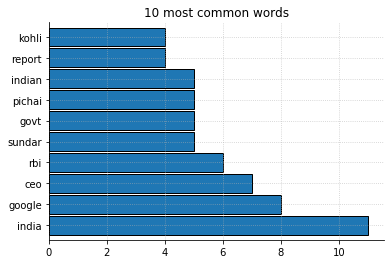

In [30]:
raw_count.sort_values(ascending=False)[0:10].plot.barh(width=.9)
plt.title('10 most common words')

In [31]:
# type(raw_count)

tf_df = pd.DataFrame({'raw_count': raw_count})

tf_df = tf_df.assign(frequency = lambda df: df.raw_count / df.raw_count.sum())

tf_df = tf_df.assign(augmented_frequency = lambda df: df.frequency / df.frequency.max())

tf_df.frequency.max()

tf_df.head()

,raw_count,frequency,augmented_frequency
india,11,0.014379,1.000000
google,8,0.010458,0.727273
ceo,7,0.009150,0.636364
rbi,6,0.007843,0.545455
sundar,5,0.006536,0.454545


In [32]:
tf_df = (pd.DataFrame({'raw_count': raw_count})
         .assign(frequency=lambda df: df.raw_count / df.raw_count.sum())
         .assign(augmented_frequency=lambda df: df.frequency / df.frequency.max()))

tf_df.head(6)

,raw_count,frequency,augmented_frequency
india,11,0.014379,1.000000
google,8,0.010458,0.727273
ceo,7,0.009150,0.636364
rbi,6,0.007843,0.545455
sundar,5,0.006536,0.454545
govt,5,0.006536,0.454545


### Inverse Document Frequency (IDF)

Inverse Document Frequency also provides information about individual words, but, in order to use this measure, we must have multiple documents, i.e. several different bodies of text.

- provides information about individual words in a document with respect the those words' frequency across the corpus, which must include multiple documents.  
- indicates how valuable a word is in terms of the information it provides.
- The more frequently a word appears in the corpus, the less information it provides when found in a certain document. This will lead to a lower IDF score. 
- Lower IDF $\rightarrow$ less important when found in a document, i.e. that word gives us less information about the document than a word with a high IDF. 
- Example: 'the' would have a *very* low IDF which indicates we learn very little about an individual document knowing that the word 'the' appears in it.  

$$
\mbox{idf}(\mbox{word})
=
\log\left(\frac{\mbox{# of documents}}{\mbox{# of documents containing the word + 1}}\right)
$$

Notes on IDF calculation

- If a given word doesn't appear in any documents, the denominator in the equation above would be zero, so it is best to add 1 to the denominator, as indicated above.   
- The denominator is *NOT* necessarily equivalent to Term Frequency, which is the total number of times the word appears in a corpus. When a word appears in a document more than once, these numbers will differ. 
    


For example, imagine we have 20 documents. We can visualize what the idf score looks like with the code below:

Text(0.5, 1.0, 'IDF for a given word')

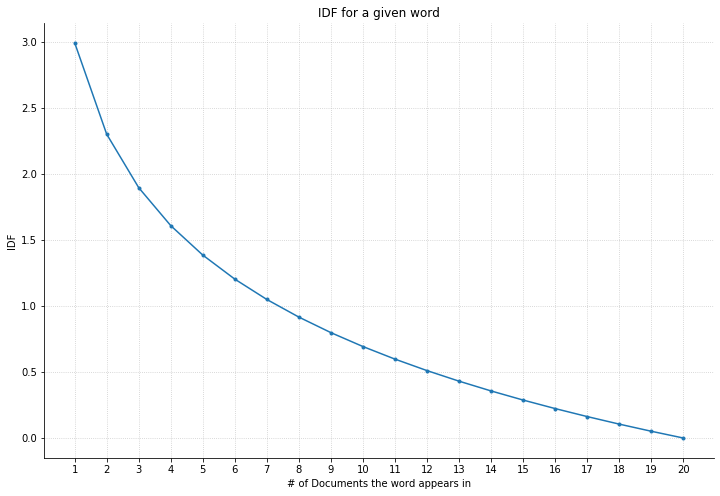

In [33]:
n_documents = 20

x_denominator = np.arange(1, n_documents + 1)
y_idf = np.log(n_documents / x_denominator)

plt.figure(figsize=(12, 8))
plt.plot(x_denominator, y_idf, marker='.')

plt.xticks(x_denominator)
plt.xlabel('# of Documents the word appears in')
plt.ylabel('IDF')
plt.title('IDF for a given word')

Compute IDF for the titles of the news ariticles. We need:  

- number of occurrences of the word (denominator)   
- total number of documents (numerator) 

First, let's compute IDF for a single word to see how it's done.  

In [34]:
print("word: india")
denom = sum([1 for doc in df.cleaned if 'india' in doc])
print("# of occurrences: ", denom)
num = len(df.cleaned)
print("# of documents: ", num)
idf = np.log(num/(denom+1))
print("idf = ", idf)

word: india
# of occurrences:  15
# of documents:  100
idf =  1.8325814637483102


Write the IDF function

In [35]:
def idf(word):
    n_occurrences = sum([1 for doc in df.cleaned if word in doc])
    n_docs = len(df.cleaned)
    idf = np.log(n_docs/n_occurrences)
    return idf

Now, we need to do it for all words in our corpus. To do that, we need:  

- list of unique words  
- assign words to a dataframe  
- calculate the idf for each word  

#### Unique Words

- join all docs together into corpus as single document
- split corpus into single words & convert to list of words
- keep only a single, unique value for each word. (dedup)


In [36]:
part1 = ' '.join(df.cleaned)
part2 = part1.split()
part3 = pd.Series(part2)
# print(part3.value_counts())

part4 = part3.unique()
type(part4)
# confirm that those words that existed multiple times, are now only represented once in the unique_words list. 
# print(pd.Series(part4).value_counts())

numpy.ndarray

In [37]:
unique_words = pd.Series(' '.join(df.cleaned).split()).unique()


- add to a dataframe
- apply idf() to compute IDF for each unique word
- sort idf_df for quick peeks into the results

In [38]:
word_df = pd.DataFrame(dict(word = unique_words))
word_df.head()

word_df = word_df.assign(idf = lambda df: df.word.apply(idf))

word_df.set_index('word').sort_values(by='idf', ascending = False).head(5)

,idf
word,
state,4.60517
satwik,4.60517
special,4.60517
old,4.60517
oneplus,4.60517


In [39]:
# put in a dataframe
idf_df = pd.DataFrame(dict(word = unique_words))\
    .assign(idf = lambda df: df.word.apply(idf))\
    .set_index('word').sort_values(by='idf', ascending = False)

idf_df.head(5)

,idf
word,
state,4.60517
satwik,4.60517
special,4.60517
old,4.60517
oneplus,4.60517


### TF-IDF

In [40]:
documents = df.cleaned.to_dict()
# documents

text = df.cleaned[0]

pd.Series(text.split()).value_counts()\
    .reset_index()\
    .set_axis(['word','raw_count'], axis=1, inplace=False)\
    .assign(tf = lambda df: df.raw_count / df.shape[0])\
    .drop(columns=['raw_count'])\
    .assign(doc=0)

,word,tf,doc
0,chidambaram,0.2,0
1,growth,0.2,0
2,economy,0.2,0
3,gdp,0.2,0
4,state,0.2,0


In [46]:
text

'shooting emraan chehre stalled fan refuse leave set'

In [41]:
# We'll caclulate the tf-idf value for every word across every document
tfs = []

# Start by iterating over all the documents
for doc, text in documents.items():
    # We'll make a data frame that contains the tf for every word in every document
    tf_df = (pd.Series(text.split())
          .value_counts()
          .reset_index()
          .set_axis(['word', 'raw_count'], axis=1, inplace=False)
          .assign(tf=lambda df: df.raw_count / df.shape[0])
          .drop(columns='raw_count')
          .assign(doc=doc))
    # Then add that data frame to our list
    tfs.append(tf_df)

In [42]:
tfs[0:2]

[          word   tf  doc
 0  chidambaram  0.2    0
 1       growth  0.2    0
 2      economy  0.2    0
 3          gdp  0.2    0
 4        state  0.2    0,        word     tf  doc
 0      gain  0.125    1
 1    sundar  0.125    1
 2  alphabet  0.125    1
 3   founder  0.125    1
 4      made  0.125    1
 5    google  0.125    1
 6    pichai  0.125    1
 7       ceo  0.125    1]

In [49]:
tfidf_df = pd.concat(tfs)\
            .assign(idf = lambda tf_df: tf_df.word.apply(idf))\
            .assign(tf_idf = lambda tf_df: tf_df.idf * tf_df.tf).sort_values(by='tf_idf', ascending=False)
            #.drop(columns=['tf', 'idf'])\
            

In [50]:
tfidf_df.head()

,word,tf,doc,idf,tf_idf
0,dhoni,0.333333,28,3.912023,1.304008
0,banking,0.250000,7,4.605170,1.151293
0,black,0.250000,34,4.605170,1.151293
0,umpire,0.250000,26,4.605170,1.151293
0,peer,0.250000,20,4.605170,1.151293


### TF-IDF with Scikit-Learn

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
tfidfs = tfidf.fit_transform(documents.values())


This returns a sparse matrix:  
- a matrix with more 0s than anything else. 
- Numpy has a special type that makes some manipulations and operations faster on sparse matrices.

Becuase our data set is pretty small, we can convert our sparse matrix to a regular one, aka 'dense matrix', and put everything in a dataframe. If our data were larger, the operation below might take much longer.

In [43]:
features_df = pd.DataFrame(tfidfs.todense(), columns=tfidf.get_feature_names())
features_df.head()

,aaryan,ab,able,account,across,actor,actress,adventurer,age,agrees,...,win,winning,without,worth,wrongly,year,yes,zero,zilingos,zurich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.370672,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Modeling

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, accuracy_score

In [53]:
tfidf_df.head()

,word,tf,doc,idf,tf_idf
0,dhoni,0.333333,28,3.912023,1.304008
0,banking,0.250000,7,4.605170,1.151293
0,black,0.250000,34,4.605170,1.151293
0,umpire,0.250000,26,4.605170,1.151293
0,peer,0.250000,20,4.605170,1.151293


In [54]:
df.head()

,category,cleaned
0,business,state economy chidambaram gdp growth
1,business,google founder gain sundar pichai made alphabe...
2,business,sundar pichai rejected google share worth mill...
3,business,gut feeling drove invest alibaba softbank ceo
4,business,maharashtra govt suggests merger pmc bank msc ...


In [69]:
# version1
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df.cleaned)
y = df.category

In [56]:
# version2
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df.cleaned)
y = df.category

In [61]:
vectorizer2 = CountVectorizer(analyzer='word', ngram_range=(2, 2))
X = vectorizer2.fit_transform(df.cleaned)
y = df.category

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2, random_state = 123)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))
# 1st model
# lm = LogisticRegression().fit(X_train, y_train)

# 2nd model
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_train)
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of KNN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))


#train['predicted'] = lm.predict(X_train)
#test['predicted'] = lm.predict(X_test)

Accuracy of KNN classifier on training set: 0.69
Accuracy of KNN classifier on test set: 0.55


In [63]:
train.head()

,actual,predicted
87,entertainment,entertainment
53,technology,technology
5,business,business
44,sports,sports
7,business,business


In [64]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 98.75%
---
Confusion Matrix
actual         business  entertainment  sports  technology
predicted                                                 
business             19              0       0           0
entertainment         0             20       0           0
sports                0              0      20           0
technology            1              0       0          20
---
               precision    recall  f1-score   support

     business       1.00      0.95      0.97        20
entertainment       1.00      1.00      1.00        20
       sports       1.00      1.00      1.00        20
   technology       0.95      1.00      0.98        20

     accuracy                           0.99        80
    macro avg       0.99      0.99      0.99        80
 weighted avg       0.99      0.99      0.99        80



In [65]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---')
print(classification_report(test.actual, test.predicted))

Accuracy: 25.00%
---
Confusion Matrix
actual      business  entertainment  sports  technology
predicted                                              
business           4              5       4           5
sports             0              0       1           0
technology         1              0       0           0
---
               precision    recall  f1-score   support

     business       0.22      0.80      0.35         5
entertainment       0.00      0.00      0.00         5
       sports       1.00      0.20      0.33         5
   technology       0.00      0.00      0.00         5

     accuracy                           0.25        20
    macro avg       0.31      0.25      0.17        20
 weighted avg       0.31      0.25      0.17        20



/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
